In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Input
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold

In [2]:
#!pip install keras-tuner

In [3]:
from numpy.random import seed
seed(1)

In [4]:
df = pd.read_csv('data/final_data.csv')
df.head()

,target,number_of_steps,sascore,scscore,syba,MolWt,MolLogP,NumHAccept,NumHDonors
0,CCS(=O)(=O)Nc1ccc(NC(=O)CCCn2cccc2)cc1,1,2.159256,3.196286,156.662693,335.429,2.6686,4,2
1,O=C(COC(=O)c1ccc(F)c(F)c1)Nc1ccc(F)cc1Cl,1,1.817674,2.670564,146.048809,343.688,3.5528,3,1
2,C=CCN(CC(=O)O)C(=O)c1ccc(NC(N)=O)cc1,4,2.085852,2.843066,76.979269,277.280,0.8900,3,3
3,CN(C)C(=O)Oc1ccc(Cl)cc1C(=O)Nc1ccc(C(F)(F)F)cc1,3,2.045999,2.822705,134.841933,386.757,4.6715,3,1
4,COc1ccc(NS(=O)(=O)c2cc(F)c(F)c(F)c2)cc1,3,1.895674,2.338246,96.252462,317.288,2.9133,3,1


In [5]:
corr = df.corr()
corr_sm = corr.number_of_steps.abs().index 
display(corr.number_of_steps.loc[corr_sm])

number_of_steps    1.000000
sascore            0.549571
scscore            0.289532
syba              -0.450635
MolWt              0.356924
MolLogP            0.097490
NumHAccept         0.271237
NumHDonors         0.151229
Name: number_of_steps, dtype: float64

Removing outliers

In [6]:
Q1 = df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.25)
Q3 = df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.75)
IQR = Q3 - Q1

In [7]:
df_drop_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

/var/tmp/pbs.45885.lich-compute.vscht.cz/ipykernel_13021/2150545488.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_drop_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [8]:
df.shape, df_drop_out.shape

((18176, 9), (16598, 9))

In [9]:
df = df_drop_out

Division into groups

In [10]:
df['steps_bins'] = pd.cut(df['number_of_steps'], [0,1,3,6,10], labels=False)
df.steps_bins.value_counts()
# (0, 1] - 0, (1, 3] - 1, (3, 6] - 2, (6, 10]- 3

1    5376
0    4905
2    3386
3    2931
Name: steps_bins, dtype: int64

# Neural Network

Visualization function taken from the article https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

In [11]:
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color  
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [12]:
def print_metrics(history):   
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4)) #sharey=True, 
    ax[0].set(title="MSE") 
    ax[0].plot(history.history['loss'], color='black')    
    ax[0].set_xlabel('Epochs')    
    ax[0].set_ylabel('MSE', color='black')  
    ax[0].plot(history.history['val_loss'], color='blue')
    ax[1].set(title="MAE") 
    ax[1].plot(history.history['mae'], color='black')    
    ax[1].set_xlabel('Epochs')    
    ax[1].set_ylabel('MAE', color='black')  
    ax[1].plot(history.history['val_mae'], color='blue')
    
def evaluate_nn(keras_model, X_train, y_train, X_test, y_test):
    print("Evaluate")
    res_train = keras_model.evaluate(X_train, y_train)
    res_test = keras_model.evaluate(X_test, y_test)
    print("\nTrain data")
    display(dict(zip(keras_model.metrics_names, res_train)))
    print("Test data")
    display(dict(zip(keras_model.metrics_names, res_test)))
    
def test_evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model.evaluate(x_test, y_test)

def cross_scoring(model, X, Y):
    cv = RepeatedKFold(n_splits=10, n_repeats=30, random_state=1)
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=cv)
    return scores

def return_round_predict(model, X_train, y_train, X_test, limit):
    model_fit = model.fit(X_train, y_train)
    predict = model_fit.predict(X_test)
    predict_r = np.array([round(y) for y in predict])
    for i in range(len(predict_r)):
        if predict_r[i] > limit:
            predict_r[i] = limit
    return predict_r  

## Prediction of four groups

In [13]:
y = np.array(df.steps_bins).ravel()
x = np.array(df[['syba', 'sascore', 'scscore','MolWt','MolLogP','NumHAccept','NumHDonors']])
x = StandardScaler().fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

There are used optimized parameters. 

In [14]:
def build_model_groups():
    model = Sequential()
    model.add(Input(x.shape[1]))
    model.add(Dense(24, activation='softmax')) 
    model.add(Dropout(rate=0.1))
    model.add(Dense(8, activation='softmax'))  
    model.add(Dense(1, activation='elu'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics='mae')
    return model

Try the optimal number of epochs. 

In [16]:
keras_model = build_model_groups()
history = keras_model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.3, batch_size=32)
loss_per_epoch = history.history['val_loss']
best_epoch = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 38


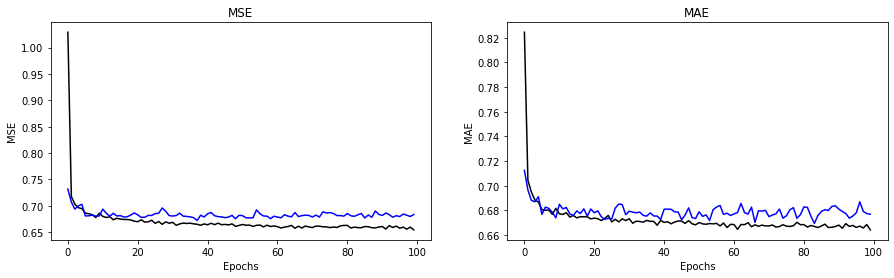

In [17]:
print_metrics(history)

In [18]:
keras_model = build_model_groups()
history = keras_model.fit(X_train, y_train, epochs=best_epoch, verbose=0, batch_size=32)

In [19]:
evaluate_nn(keras_model, X_train, y_train, X_test, y_test)

Evaluate
130/130 [==============================] - 0s 2ms/step - loss: 0.6491 - mae: 0.6608

Train data


{'loss': 0.6556884050369263, 'mae': 0.6647955775260925}

Test data


{'loss': 0.6490547060966492, 'mae': 0.660759687423706}

In [20]:
kFold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True) 
scores = []
n_repeats=30
for i in range(n_repeats):
    for train, test in kFold.split(x, y):
        model = build_model_groups()
        scores.append(test_evaluate(model, x[train], y[train], x[test], y[test]))

52/52 [==============================] - 0s 3ms/step - loss: 0.6478 - mae: 0.6689


52/52 [==============================] - 0s 2ms/step - loss: 0.7010 - mae: 0.6972


52/52 [==============================] - 0s 2ms/step - loss: 0.6846 - mae: 0.6933


52/52 [==============================] - 0s 2ms/step - loss: 0.7107 - mae: 0.6971


52/52 [==============================] - 0s 2ms/step - loss: 0.7027 - mae: 0.6996


52/52 [==============================] - 0s 2ms/step - loss: 0.6948 - mae: 0.6904


52/52 [==============================] - 0s 2ms/step - loss: 0.6880 - mae: 0.6858


In [21]:
d = pd.DataFrame.from_dict(scores)
d = d.rename(columns={0:'test_MSE',1:'test_MAE'})

In [22]:
d['test_MSE'].mean(), d['test_MAE'].mean() 

(0.6931207698583602, 0.6919567783673605)

In [23]:
keras_model = build_model_groups()
keras_model.fit(X_train, y_train, epochs=best_epoch, verbose=0, batch_size=32)
predict = keras_model.predict(X_test)
predict_MLP = np.array([round(predict[i][0]) for i in range(len(predict))])

130/130 [==============================] - 0s 1ms/step


Confusion matrix on test data

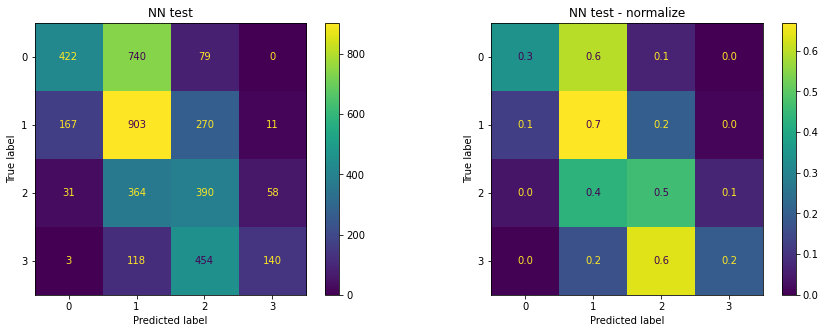

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_MLP)).plot(ax=ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, predict_MLP, ax=ax[1], normalize = 'true', values_format='.1f')
ax[0].set_title("NN test")
ax[1].set_title("NN test - normalize")
plt.show()

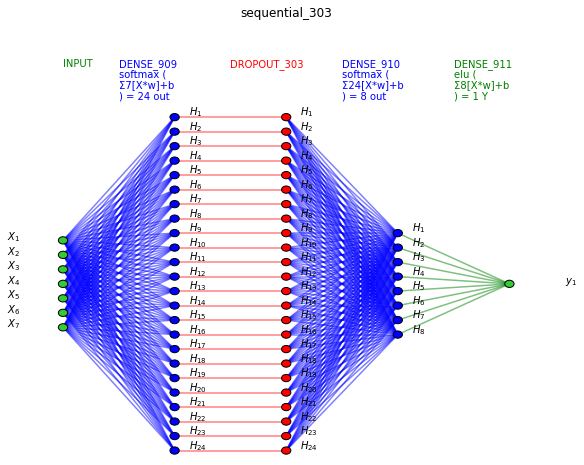

In [25]:
visualize_nn(keras_model, description=True, figsize=(10,8))

## Number of steps prediction

In [26]:
y2 = np.array(df.number_of_steps).ravel()
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y2, test_size=0.25, random_state=1)

There are also used optimized parameters. 

In [27]:
def build_model_steps():
    model = Sequential()
    model.add(Input(x.shape[1]))
    model.add(Dense(18, activation='elu'))
    model.add(Dense(18, activation='softmax')) 
    model.add(Dropout(rate=0.1))
    model.add(Dense(14, activation='sigmoid'))
    model.add(Dense(1, activation='elu'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics='mae')
    return model

In [30]:
keras_model_steps = build_model_steps()
history = keras_model_steps.fit(X_train2, y_train2, epochs=100, verbose=0, validation_split=0.3, batch_size=32)
loss_per_epoch = history.history['val_loss']
best_epoch2 = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch2,))

Best epoch: 26


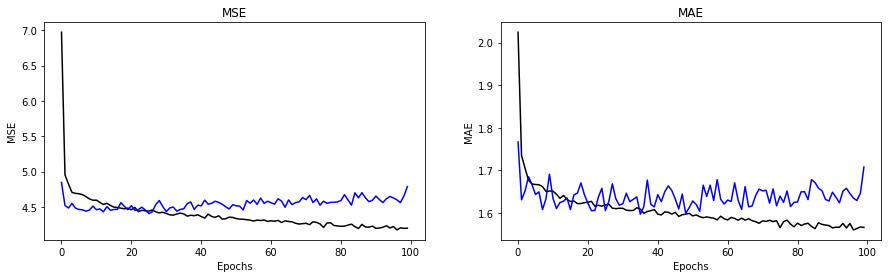

In [31]:
print_metrics(history)

In [32]:
keras_model_steps = build_model_steps()
history = keras_model_steps.fit(X_train2, y_train2, epochs=best_epoch2, verbose=0, batch_size=32)

In [33]:
evaluate_nn(keras_model_steps, X_train2, y_train2, X_test2, y_test2)

Evaluate
130/130 [==============================] - 1s 3ms/step - loss: 4.2767 - mae: 1.5926

Train data


{'loss': 4.310002326965332, 'mae': 1.5964512825012207}

Test data


{'loss': 4.276689052581787, 'mae': 1.592610239982605}

In [34]:
kFold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True) 
n_repeats=30
scores2 = []
for i in range(n_repeats):
    for train, test in kFold.split(x, y2):
        model = build_model_steps()
        scores2.append(test_evaluate(model, x[train], y2[train], x[test], y2[test]))

52/52 [==============================] - 0s 2ms/step - loss: 4.5292 - mae: 1.6768


52/52 [==============================] - 0s 2ms/step - loss: 4.5435 - mae: 1.5899


52/52 [==============================] - 0s 3ms/step - loss: 4.5471 - mae: 1.6755


52/52 [==============================] - 0s 2ms/step - loss: 4.6986 - mae: 1.6818


52/52 [==============================] - 0s 2ms/step - loss: 4.3138 - mae: 1.6040


52/52 [==============================] - 0s 2ms/step - loss: 4.6108 - mae: 1.7082


52/52 [==============================] - 0s 2ms/step - loss: 4.5805 - mae: 1.6952


In [35]:
d2 = pd.DataFrame.from_dict(scores2)
d2 = d2.rename(columns={0:'test_MSE',1:'test_MAE'})

In [36]:
d2['test_MSE'].mean(), d2['test_MAE'].mean() 

(4.584469126065572, 1.6663097174962362)

Confusion matrix on test data

In [44]:
keras_model_steps = build_model_steps()
keras_model_steps.fit(X_train2, y_train2, epochs=best_epoch2, verbose=0, batch_size=32) 
predict_ste = keras_model_steps.predict(X_test2)
predict_MLP_ste = np.array([round(predict_ste[i][0]) for i in range(len(predict_ste))])

130/130 [==============================] - 0s 1ms/step


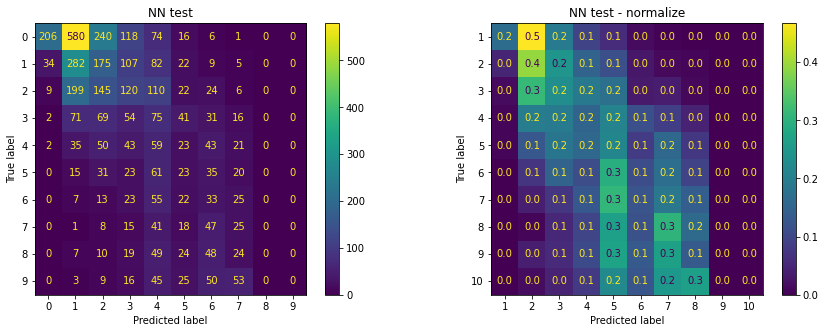

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_MLP_ste)).plot(ax=ax[0])
ConfusionMatrixDisplay.from_predictions(y_test2, predict_MLP_ste, ax=ax[1], normalize = 'true', values_format='.1f')
ax[0].set_title("NN test")
ax[1].set_title("NN test - normalize")
plt.show()

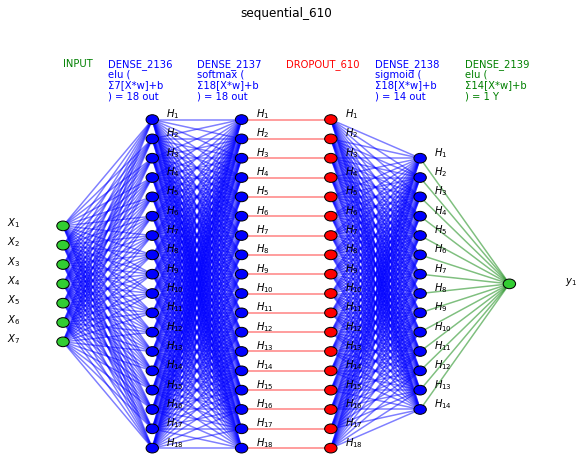

In [46]:
visualize_nn(keras_model_steps, description=True, figsize=(10,8))